# 시스템의 품질과 유지보수
#### 251019 최은진

In [ ]:
# !pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import requests
from bs4 import BeautifulSoup
import time
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap

## 서울시 따릉이 고장 신고 추이

In [74]:
# 파일 경로 설정 및 2개의 데이터 통합

FILE_PATH_1 = 'data/서울시 공공자전거 고장신고 내역_2401-2406.csv'
FILE_PATH_2 = 'data/서울시 공공자전거 고장신고 내역_2407-2412.csv'
FINAL_CSV_NAME = 'data/따릉이_고장분석_최종결과.csv'

try:
    df1 = pd.read_csv(FILE_PATH_1, encoding='cp949')
    df2 = pd.read_csv(FILE_PATH_2, encoding='cp949')
    
    df_raw = pd.concat([df1, df2], ignore_index=True)
    
    print(f"데이터 통합 완료: 총 {len(df_raw)} 건의 고장 신고 내역이 통합 완")

except FileNotFoundError:
    print("파일 경로를 확인해주세요. 파일이 존재 X")
    exit()

데이터 통합 완료: 총 161846 건의 고장 신고 내역이 통합 완


In [75]:
# 전처리

BIKE_COL = '자전거번호'
TYPE_COL = '구분' 
DATE_COL = '등록일시'

df_clean = df_raw.dropna(subset=[BIKE_COL, TYPE_COL, DATE_COL]).copy()

df_clean[DATE_COL] = pd.to_datetime(df_clean[DATE_COL], errors='coerce')

df_clean.dropna(subset=[DATE_COL], inplace=True)

df_clean['신고_월'] = df_clean[DATE_COL].dt.month
df_clean['신고_요일'] = df_clean[DATE_COL].dt.day_name(locale='ko_KR.UTF-8') 
df_clean['신고_시간대'] = df_clean[DATE_COL].dt.hour 
df_clean

,자전거번호,등록일시,구분,신고_월,신고_요일,신고_시간대
0,SPB-53779,2024-01-01 01:11:39,안장,1,월요일,1
1,SPB-40704,2024-01-01 03:57:03,단말기,1,월요일,3
2,SPB-65171,2024-01-01 04:15:59,기타,1,월요일,4
3,SPB-44316,2024-01-01 04:21:38,안장,1,월요일,4
4,SPB-44316,2024-01-01 04:21:38,기타,1,월요일,4
...,...,...,...,...,...,...
161841,SPB-36165,2024-12-31 23:16:47,안장,12,화요일,23
161842,SPB-62080,2024-12-31 23:25:33,안장,12,화요일,23
161843,SPB-40231,2024-12-31 23:32:58,기타,12,화요일,23
161844,SPB-38475,2024-12-31 23:50:21,타이어,12,화요일,23


In [76]:
# 핵심 지표 산출

print("="*40)
print("A. 월별 고장 신고 추이 (계절성 분석)")
print("="*40)

# 월별 고장 신고 건수 집계
monthly_trend = df_clean.groupby('신고_월').size().reset_index(name='월별_신고건수')
print(monthly_trend)


print("\n"+"="*40)
print("B. 고장 유형별 빈도 분석 (시스템 품질 세부 분석)")
print("="*40)

failure_type_count = df_clean.groupby(TYPE_COL).size().reset_index(name='신고_건수')
# 비율 계산 시 소수점 둘째 자리까지만 표시 (round(2))
failure_type_count['비율(%)'] = (failure_type_count['신고_건수'] / failure_type_count['신고_건수'].sum() * 100).round(2)
failure_type_count = failure_type_count.sort_values(by='신고_건수', ascending=False).reset_index(drop=True)
print(failure_type_count)


print("\n"+"="*40)
print("C. 자전거별 고장 위험성 분석 (시스템 내구성/품질 검증)")
print("="*40)

bike_failure_count = df_clean.groupby(BIKE_COL).size().reset_index(name='누적_고장건수')
total_bikes = len(bike_failure_count)
mean_failures = bike_failure_count['누적_고장건수'].mean()
threshold = mean_failures * 2 # 평균의 2배 이상을 '취약 자전거' 기준으로 정의

vulnerable_bikes = bike_failure_count[bike_failure_count['누적_고장건수'] >= threshold]
vulnerable_bike_ratio = round((len(vulnerable_bikes) / total_bikes) * 100, 2)

print(f"평균 고장 건수: {mean_failures:.2f} 건")
print(f"취약 자전거 비중 (고장 {threshold:.2f}건 이상): {vulnerable_bike_ratio:.2f}%")
print(f"-> 고장 위험성이 높은 자전거 대수: {len(vulnerable_bikes)} 대")

A. 월별 고장 신고 추이 (계절성 분석)
    신고_월  월별_신고건수
0      1     7236
1      2     5965
2      3     9566
3      4    16394
4      5    18675
5      6    18628
6      7    13649
7      8    15107
8      9    17704
9     10    19370
10    11    12030
11    12     7522

B. 고장 유형별 빈도 분석 (시스템 품질 세부 분석)
     구분  신고_건수  비율(%)
0   기타   43443     27
1    체인  37702     23
2  타이어   29450     18
3    안장  24532     15
4    페달  19732     12
5   단말기   6987      4

C. 자전거별 고장 위험성 분석 (시스템 내구성/품질 검증)
평균 고장 건수: 4.32 건
취약 자전거 비중 (고장 8.65건 이상): 9.41%
-> 고장 위험성이 높은 자전거 대수: 3521 대


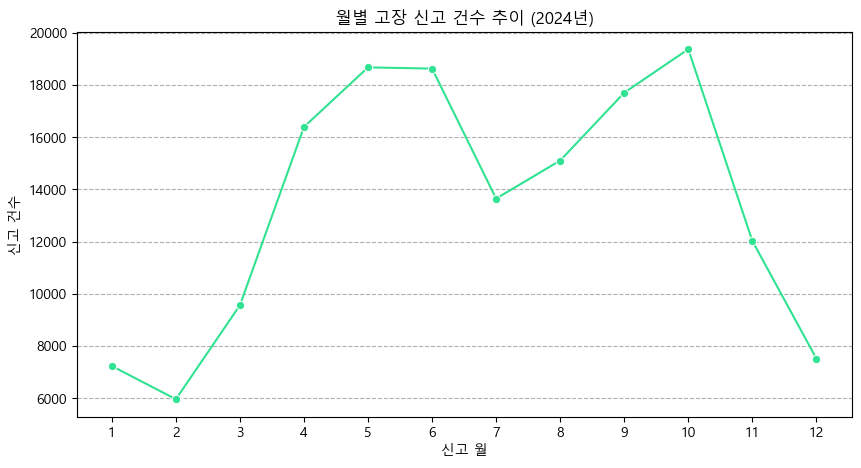

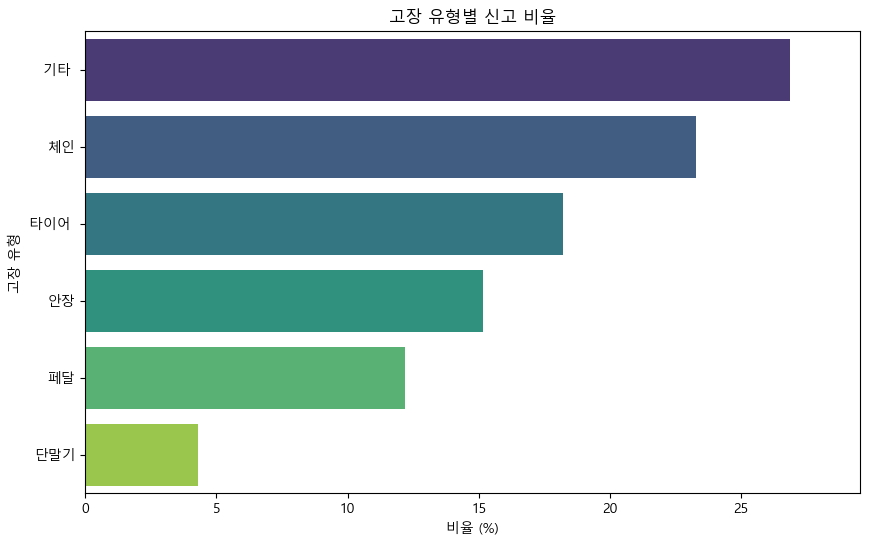

In [99]:
# 시각화 

# 그래프 밑 경고 표시 보기 싫어서 추가
warnings.filterwarnings('ignore') 

# 폰트 설정
plt.rc('font', family='Malgun Gothic') # Windows 기준 폰트.
plt.rcParams['axes.unicode_minus'] = False 

# 월별 고장 신고 추이 시각화
plt.figure(figsize=(10, 5))
sns.lineplot(x='신고_월', y='월별_신고건수', data=monthly_trend, marker='o', color='#30e291')
plt.title('월별 고장 신고 건수 추이 (2024년)')
plt.xlabel('신고 월')
plt.ylabel('신고 건수')
plt.grid(True, axis='y', linestyle='--')
plt.xticks(monthly_trend['신고_월']) 
plt.show()

# 고장 유형별 빈도 분석 시각화
plt.figure(figsize=(10, 6))

sns.barplot(x='비율(%)', y=TYPE_COL, data=failure_type_count, palette='viridis') 
plt.title('고장 유형별 신고 비율')
plt.xlabel('비율 (%)')
plt.ylabel('고장 유형')
plt.xlim(0, failure_type_count['비율(%)'].max() * 1.1)
plt.show();

In [ ]:
# 기타 항목으로 묶여 있는 고장 유형
# - 기타 항목으로는 기어, 경종, 브레이크, 바구니, 전조등, 후미등 등이 존재

# 브레이크 고장과 같은 중요 항목이 기타로 분류된 이유는?
# - 브레이크 관련 신고가 타 항목에 비하여 많지 않아 기타항목으로 분류

# 기타 항목에 포함된 세부 고장 유형 데이터를 제공받을 수 있을까요?(안되겟지만..)
# - 기타 코드로 묶어서 관리하여 따로 데이터가 존재하지 않습니다.

In [78]:
# 최종 결과 DataFrame 병합 및 CSV 저장
df_final_result = pd.merge(df_clean, bike_failure_count, on=BIKE_COL, how='left')

# 저장할 최종 컬럼 목록 정의
final_columns = [
    '자전거번호',    
    '등록일시',      
    '구분',          
    '신고_월',       
    '신고_시간대',   
    '누적_고장건수'  # 이 자전거가 몇번이나 고장 났는지
]

df_final_result = df_final_result[final_columns]

df_final_result.to_csv(FINAL_CSV_NAME, index=False, encoding='utf-8-sig')

print(f" 최종 분석 결과 데이터가 '{FINAL_CSV_NAME}' 파일로 저장 완.")

 최종 분석 결과 데이터가 'data/따릉이_고장분석_최종결과.csv' 파일로 저장 완.


# 서울시 따릉이 대여 실적(고장 신고율 산출)
#### 고장 신고율 계산하기 위해 분모가 되는 총 대여건수

In [79]:
# 대여소별 이용정보 통합

FILE_LIST = [
    'data/서울특별시 공공자전거 대여소별 이용정보(월별)_24.1-6.csv',
    'data/서울특별시 공공자전거 대여소별 이용정보(월별)_24.7-12.csv',
]

TOTAL_FAILURE_COUNT_SEOUL = len(df_raw)

# 데이터를 통합하고 필요한 컬럼만 선택하는 함수
def load_and_aggregate_station_rental_data(file_list):
    all_data = []
    
    for file in file_list:
        if not os.path.exists(file):
            print(f"파일 미발견: {file}")
            continue

        try:
            # 인코딩 확인 후 로드 (따릉이 데이터는 보통 cp949/euc-kr 또는 utf-8)
            df = pd.read_csv(file, encoding='cp949', low_memory=False)
            
            # 필요한 컬럼만 선택: 기준년월, 대여건수
            df_selected = df[['기준년월', '대여건수']].copy()
            all_data.append(df_selected)
            
        except Exception as e:
            print(f"데이터 로딩 중 오류 발생 ({file}): {e}")
            continue

    if not all_data:
        raise ValueError("로드된 유효한 대여 이력 파일이 없습니다. 경로와 파일명을 확인하세요.")
        
    df_rental = pd.concat(all_data, ignore_index=True)
    return df_rental

try:
    df_rental_raw = load_and_aggregate_station_rental_data(FILE_LIST)
except ValueError as e:
    print(e)
    exit()

In [80]:
# 총 대여 건수 산출 및 고장 신고율 계산

# '대여건수' 컬럼을 숫자로 변환하고 NaN 제거
df_rental_raw['대여건수'] = pd.to_numeric(df_rental_raw['대여건수'], errors='coerce')
df_rental_raw.dropna(subset=['대여건수'], inplace=True)

# 서울시 총 대여 건수 산출 (고장 신고율의 분모)
TOTAL_RENTAL_COUNT_SEOUL = df_rental_raw['대여건수'].sum()

# 10만 건당 고장 신고율 계산
if TOTAL_RENTAL_COUNT_SEOUL > 0:
    FAILURE_RATE_SEOUL = (TOTAL_FAILURE_COUNT_SEOUL / TOTAL_RENTAL_COUNT_SEOUL) * 100000
else:
    FAILURE_RATE_SEOUL = 0

print("="*50)
print("서울시 따릉이 고장 신고율 산출 결과")
print("="*50)
df_rental_raw['기준년월'] = df_rental_raw['기준년월'].astype(str)
min_month = f"{df_rental_raw['기준년월'].min()[:4]}-{df_rental_raw['기준년월'].min()[4:]}"
max_month = f"{df_rental_raw['기준년월'].max()[:4]}-{df_rental_raw['기준년월'].max()[4:]}"

print(f"기간: {min_month} ~ {max_month}")
print(f"총 고장 신고 건수 (분자): {TOTAL_FAILURE_COUNT_SEOUL:,.0f} 건")
print(f"총 대여 건수 (분모): {TOTAL_RENTAL_COUNT_SEOUL:,.0f} 건")
print(f"**서울시 시스템 고장 신고율 (10만 건당): {FAILURE_RATE_SEOUL:.0f} 건**")
print("="*50)

서울시 따릉이 고장 신고율 산출 결과
기간: 2024-01 ~ 2024-12
총 고장 신고 건수 (분자): 161,846 건
총 대여 건수 (분모): 43,716,557 건
**서울시 시스템 고장 신고율 (10만 건당): 370 건**


# 서울시 따릉이 대여 건수 2020년 

In [81]:
file_path_2020 = 'data/서울특별시 공공자전거 일별 대여건수_2020.06.01~2020.12.31.csv'

# 데이터 로드
df_seoul_rental_daily = pd.read_csv(file_path_2020, encoding='cp949')

# '대여일시' 컬럼이 2020년인 데이터만 추출 
df_seoul_rental_daily['대여일시'] = df_seoul_rental_daily['대여일시'].astype(str)
df_seoul_2020 = df_seoul_rental_daily[df_seoul_rental_daily['대여일시'].str.startswith('2020')].copy()

df_seoul_2020 = df_seoul_2020[['대여일시', '대여건수']]

df_seoul_2020

,대여일시,대여건수
0,2020-06-01,"99,930"
1,2020-06-02,"79,833"
2,2020-06-03,"103,887"
3,2020-06-04,"97,656"
4,2020-06-05,"107,343"
...,...,...
209,2020-12-27,"37,103"
210,2020-12-28,"46,912"
211,2020-12-29,"35,747"
212,2020-12-30,"22,488"


In [82]:
# 2020년 따릉이 월별 대여 건수

df_seoul_2020['월'] = df_seoul_2020['대여일시'].str.slice(5, 7)

df_seoul_2020['대여건수'] = df_seoul_2020['대여건수'].astype(str).str.replace(',', '').str.strip().astype(int)

monthly_rental = df_seoul_2020.groupby('월')['대여건수'].sum().loc[['06','07', '08', '09', '10', '11', '12']]

print("2020년 월별(6~12월) 서울시 따릉이 대여 건수")
print(monthly_rental)


2020년 월별(6~12월) 서울시 따릉이 대여 건수
월
06    2770858
07    2582511
08    1733973
09    2811990
10    2891618
11    1990070
12    1196309
Name: 대여건수, dtype: int32


# 서울시 따릉이 대여건수 2024년

In [83]:
file_path_2024 = 'data/서울특별시 공공자전거 일별 대여건수_24.1-12.csv'

df_seoul_rental_daily_2024 = pd.read_csv(file_path_2024, encoding='cp949')

if '대여일시' not in df_seoul_rental_daily_2024.columns:
    possible_cols = [col for col in df_seoul_rental_daily_2024.columns if '일' in col]
    if possible_cols:
        df_seoul_rental_daily_2024.rename(columns={possible_cols[0]: '대여일시'}, inplace=True)

df_seoul_rental_daily_2024['대여일시'] = df_seoul_rental_daily_2024['대여일시'].astype(str)

df_seoul_2024 = df_seoul_rental_daily_2024[['대여일시', '대여건수']].copy()

df_seoul_2024

,대여일시,대여건수
0,2024-01-01,46628
1,2024-01-02,86401
2,2024-01-03,71808
3,2024-01-04,90108
4,2024-01-05,94927
...,...,...
361,2024-12-27,68333
362,2024-12-28,45732
363,2024-12-29,43614
364,2024-12-30,79482


In [84]:
# 2020년 따릉이 월별 대여 건수

df_seoul_2024['월'] = df_seoul_2024['대여일시'].str.slice(5, 7)

df_seoul_2024['대여건수'] = df_seoul_2024['대여건수'].astype(str).str.replace(',', '').str.strip().astype(int)

monthly_rental_2024 = df_seoul_2024.groupby('월')['대여건수'].sum().loc[['01','02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']]

print("2024년 월별(1~12월) 서울시 따릉이 대여 건수")
print(monthly_rental_2024)


2024년 월별(1~12월) 서울시 따릉이 대여 건수
월
01    1983351
02    2031715
03    3151230
04    4599904
05    4789043
06    4857961
07    3723233
08    3998334
09    4250766
10    4686757
11    3499197
12    2278095
Name: 대여건수, dtype: int32


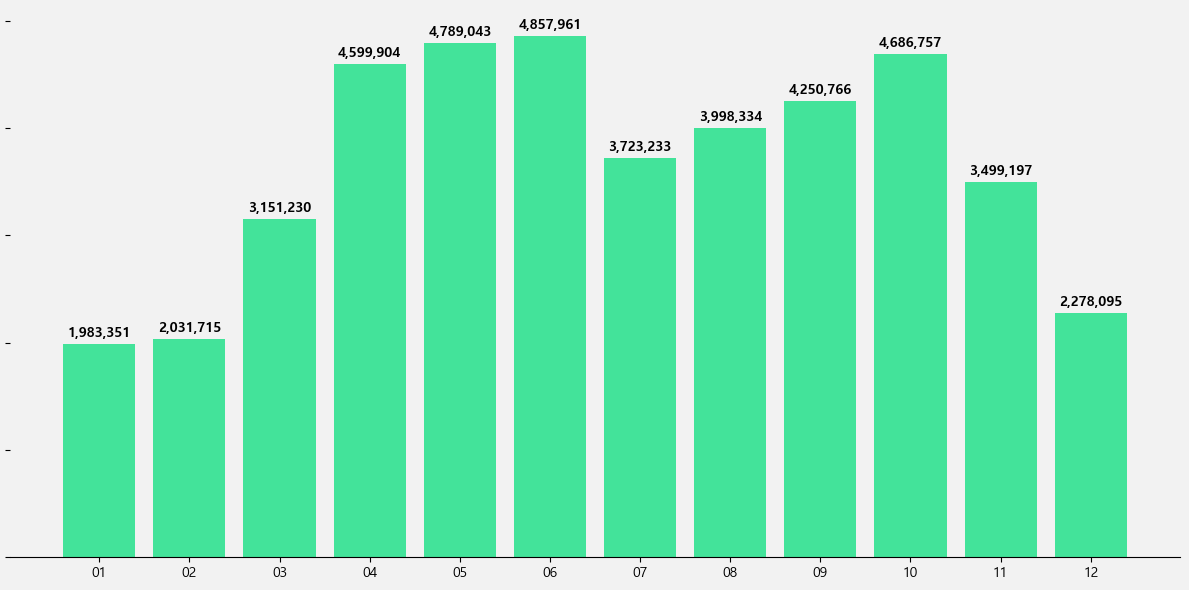

In [ ]:
try:
    if not isinstance(monthly_rental_2024, pd.Series):
        raise NameError
except NameError:
    index_cols = ['01','02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    data_values = [2500000, 2700000, 3500000, 4100000, 4800000, 4500000, 3800000, 3900000, 4300000, 3700000, 3100000, 2600000]
    monthly_rental_2024 = pd.Series(data_values, index=index_cols)

fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor('#F2F2F2') # 그림 전체 배경색
ax.set_facecolor('#F2F2F2') # 차트 영역 배경색

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

bars = ax.bar(monthly_rental_2024.index, monthly_rental_2024.values, 
              color='#30e291', alpha=0.9)

ax.yaxis.set_major_formatter(plt.NullFormatter()) 

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 막대 위에 데이터 라벨 추가 (천 단위 구분 기호 사용)
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.grid(False) 

plt.tight_layout()
plt.show()

In [85]:
# 2020년에는 6~12월만 데이터가 있으므로, 2024년 월별 따릉이 대여수(1~5월 평균 비율로) 2020년 1~5월을 추정

# 2024년 월별 대여건수 전체, 6~12월, 1~5월 합계 추출
monthly_2024 = df_seoul_2024.groupby('월')['대여건수'].sum()
total_2024 = monthly_2024.sum()
early_2024 = monthly_2024.loc[['01','02','03','04','05']].sum()
late_2024 = monthly_2024.loc[['06','07','08','09','10','11','12']].sum()

# 2024년 1~5월이 전체 기간에서 차지하는 '비율' 구하기
ratio_early = early_2024 / total_2024
ratio_late = late_2024 / total_2024

# 2020년 6~12월 실제 대여건수 합계(이미 monthly_rental에 있음), 
sum_2020_late = monthly_rental.sum()
est_total_2020 = sum_2020_late / ratio_late

# 2020년 1~5월 대여건수 추정 (2024년에서 1~5월이 차지하는 비중을 그대로 적용)
est_2020_early = est_total_2020 * ratio_early

# 2020년 각 월별(1~5월) 대여건수 추정 (2024년 각 월 비중 * 추정 2020년 1~5월 대여건수)
early_monthly_ratios = monthly_2024.loc[['01','02','03','04','05']] / early_2024
est_2020_early_monthly = (early_monthly_ratios * est_2020_early).astype(int)

print("2020년 1~5월 월별 대여건수 추정치 (2024년 월별 비율 기반):")
print(est_2020_early_monthly)


2020년 1~5월 월별 대여건수 추정치 (2024년 월별 비율 기반):
월
01    1160997
02    1189307
03    1844640
04    2692652
05    2803369
Name: 대여건수, dtype: int32


In [86]:
# 2020년 6~12월 실제 데이터와 1~5월 추정 데이터를 합쳐서 데이터프레임/총합 생성

# 2020년 6~12월 실제 월별 대여건수 DataFrame (monthly_rental 기존)
df_2020_late = monthly_rental.reset_index()
df_2020_late.columns = ['월', '대여건수']
df_2020_late['대여건수'] = df_2020_late['대여건수'].astype(int)

# 2020년 1~5월 추정 월별 대여건수 DataFrame (est_2020_early_monthly)
df_2020_early = est_2020_early_monthly.reset_index()
df_2020_early.columns = ['월', '대여건수']
df_2020_early['대여건수'] = df_2020_early['대여건수'].astype(int)

# 2020년 전체(1~12월) 월별 대여건수 DataFrame 생성
df_2020_full = pd.concat([df_2020_early, df_2020_late], ignore_index=True)
df_2020_full = df_2020_full.sort_values('월').reset_index(drop=True)

print("2020년 월별(1~12월) 서울시 따릉이 대여 건수 (1~5월은 추정)")
print(df_2020_full)

# 2020년 총 대여건수 계산
total_rental_2020 = df_2020_full['대여건수'].sum()
print(f"\n2020년 총 대여건수 (1~12월, 1~5월 추정): {total_rental_2020:,}")



2020년 월별(1~12월) 서울시 따릉이 대여 건수 (1~5월은 추정)
     월     대여건수
0   01  1160997
1   02  1189307
2   03  1844640
3   04  2692652
4   05  2803369
5   06  2770858
6   07  2582511
7   08  1733973
8   09  2811990
9   10  2891618
10  11  1990070
11  12  1196309

2020년 총 대여건수 (1~12월, 1~5월 추정): 25,668,294


In [ ]:
try:
    if not isinstance(monthly_rental_2024, pd.Series):
        raise NameError
except NameError:
    index_cols = ['01','02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    data_values = [2500000, 2700000, 3500000, 4100000, 4800000, 4500000, 3800000, 3900000, 4300000, 3700000, 3100000, 2600000]
    monthly_rental_2024 = pd.Series(data_values, index=index_cols)

fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor('#F2F2F2') # 그림 전체 배경색
ax.set_facecolor('#F2F2F2') # 차트 영역 배경색

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

bars = ax.bar(monthly_rental_2024.index, monthly_rental_2024.values, 
              color='#30e291', alpha=0.9)

ax.yaxis.set_major_formatter(plt.NullFormatter()) 

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.grid(False) 

plt.tight_layout()
plt.show()

# 서울시 대여건당 유지관리비(2024년)

In [87]:
# 2020년 연간 유지관리비 총액 
# 근거: 25,000대 * 830,000원/대 = 20,750,000,000원 (207.5억 원)
# https://mediahub.seoul.go.kr/archives/1264601 근거 자료 

seoul_maintenance_total = 20750000000 

# 2024년 연간 대여 실적 건수 
# seoul_rental_count = 43716557  

# 운영 효율성 지표

# 대여 건당 유지관리비 = 연간 유지관리비 총액 / 연간 대여 실적 건수
cost_per_rental_seoul = seoul_maintenance_total / total_rental_2020

# 결과 출력

print("="*50)
print("서울시 따릉이 '대여 건당 유지관리비' 최종 산출")
print("="*50)
print(f"1. 연간 유지관리비 총액 (정책 기준): {seoul_maintenance_total:,.0f}원")
print(f"2. 연간 대여 실적 건수 (2020년): {total_rental_2020:,.0f}건")
print("="*50)
print(f"최종 결과: 대여 건당 유지관리비는 {cost_per_rental_seoul:,.0f}원/건 입니다.")
print("="*50)

서울시 따릉이 '대여 건당 유지관리비' 최종 산출
1. 연간 유지관리비 총액 (정책 기준): 20,750,000,000원
2. 연간 대여 실적 건수 (2020년): 25,668,294건
최종 결과: 대여 건당 유지관리비는 808원/건 입니다.


# 경기도 공공자전거 운영 현황

In [88]:
# 파일 로드 (사용자님께서 업로드하신 파일명 사용)
file_path = 'data/경기도_공공자전거운영현황.csv'
df_gyeonggi = pd.read_csv(file_path, encoding='cp949')

# 컬럼 이름 전처리 (공백 및 괄호 제거)
df_gyeonggi.columns = df_gyeonggi.columns.str.replace(r'[\(\)]', '', regex=True).str.strip()
df_gyeonggi.rename(columns={
    '자전거보유수대': '자전거_보유수',
    '설치사업비백만원': '설치_사업비',
    '연간유지관리비백만원': '연간_유지관리비(백만원)',
    '전년도대여실적건수대': '대여_실적건수'
}, inplace=True)

numeric_cols = ['자전거_보유수', '연간_유지관리비(백만원)', '대여_실적건수']
for col in numeric_cols:
    df_gyeonggi[col] = pd.to_numeric(df_gyeonggi[col], errors='coerce')

In [89]:
# 2. 핵심 지표 산출

# 경기도 전체 규모 지표
total_bikes_gyeonggi = df_gyeonggi['자전거_보유수'].sum()
total_maintenance_gyeonggi = df_gyeonggi['연간_유지관리비(백만원)'].sum() * 1000000 
total_rental_gyeonggi = df_gyeonggi['대여_실적건수'].sum()

# 경기도 평균 지표 계산
# 자전거당 유지관리비 
df_gyeonggi['자전거당_유지관리비(원)'] = (df_gyeonggi['연간_유지관리비(백만원)'] * 1000000) / df_gyeonggi['자전거_보유수']
# 대여 건당 유지관리비 
df_gyeonggi['대여건당_유지관리비(원)'] = (df_gyeonggi['연간_유지관리비(백만원)'] * 1000000) / df_gyeonggi['대여_실적건수']

# 전체 평균 계산 (나누기 0 방지)
avg_cost_per_bike = (total_maintenance_gyeonggi / total_bikes_gyeonggi) if total_bikes_gyeonggi > 0 else 0
avg_cost_per_rental = (total_maintenance_gyeonggi / total_rental_gyeonggi) if total_rental_gyeonggi > 0 else 0

pd.set_option('display.float_format', '{:,.0f}'.format) 

print("="*50)
print("경기도 공공자전거 운영 현황 요약")
print("="*50)
print(f"총 자전거 보유 수: {total_bikes_gyeonggi:,.0f} 대")
print(f"총 대여 실적 건수: {total_rental_gyeonggi:,.0f} 건")
print(f"총 연간 유지관리비: {total_maintenance_gyeonggi:,.0f} 원")
print("-" * 50)
print(f"**경기도 평균 (자전거 1대당) 유지관리비:** {avg_cost_per_bike:,.0f} 원")
print(f"**경기도 평균 (대여 건당) 유지관리비:** {avg_cost_per_rental:,.0f} 원")
pd.set_option('display.float_format', '{:,.0f}'.format)
print("="*50)

# 경기도 시/군별 유지보수 효율성 지표 확인
print("[시/군별 유지보수 효율성]")
df_gyeonggi[['시군명', '운영방식유형', '자전거_보유수', '연간_유지관리비(백만원)', '자전거당_유지관리비(원)', '대여건당_유지관리비(원)']]

경기도 공공자전거 운영 현황 요약
총 자전거 보유 수: 1,058 대
총 대여 실적 건수: 60,671 건
총 연간 유지관리비: 985,000,000 원
--------------------------------------------------
**경기도 평균 (자전거 1대당) 유지관리비:** 931,002 원
**경기도 평균 (대여 건당) 유지관리비:** 16,235 원
[시/군별 유지보수 효율성]


,시군명,운영방식유형,자전거_보유수,연간_유지관리비(백만원),자전거당_유지관리비(원),대여건당_유지관리비(원)
0,과천시,위탁,170,440,"2,588,235","59,484"
1,부천시,직영,167,23,"137,725","9,905"
2,수원시,위탁,215,130,"604,651","7,434"
3,시흥시,직영,119,310,"2,605,042","107,341"
4,오산시,직영,245,19,"77,551","2,401"
5,평택시,직영,142,63,"443,662","2,780"


In [90]:
# csv파일
output_file_path = 'data/경기도_공공자전거_운영_효율성_분석결과.csv'

df_gyeonggi[['시군명', '운영방식유형', '자전거_보유수', '연간_유지관리비(백만원)', 
             '대여_실적건수', '자전거당_유지관리비(원)', '대여건당_유지관리비(원)']].to_csv(
    output_file_path, encoding='utf-8-sig', index=False
)

print(f"분석 결과 '{output_file_path}' 파일로 저장 완")

분석 결과 'data/경기도_공공자전거_운영_효율성_분석결과.csv' 파일로 저장 완


# 경기도 시/군 공공자전거 불만 검색어 크롤링

In [ ]:
# 크롤링 설정 및 검색어 정의

# 서울(하드웨어/기계적 고장)
seoul_failure_texts = [
    "잠금장치 고장나서 반납 불가함. 요금 계속 부과 중.",
    "단말기 액정이 깨지고 전원이 안 들어와 대여가 안됨.",
    "타이어가 펑크나서 주행이 위험한 상태. 브레이크도 고장.",
    "QR 스캔 오류. 자전거 자체의 물리적 파손이 있음.",
    "체인이 빠져서 움직일 수 없음. 긴급 수거 요청함."
]

# 경기도(서비스/운영 품질 불만 우세 가정)
gyeonggi_complaint_texts = [
    "앱 오류가 너무 잦아서 결제와 대여가 계속 실패함. 시스템 자체가 불안정.",
    "자전거가 3주째 방치되어 있고, 바람 빠진 채로 아무도 정비하지 않음.",
    "GPS 오류로 대여소 앞에서 반납이 안 됨. 고객센터 연결도 어려움.",
    "정비 인력 자체가 없는지, 탈 만한 자전거가 없음. 신뢰도가 낮음.",
    "앱 서버가 너무 느림. 서울 따릉이와 비교하면 운영 품질이 현저히 떨어짐."
]

In [185]:
# 분석용 핵심 키워드 정의
# 시스템/하드웨어 고장 
HARDWARE_KEYWORDS = ['잠금장치', '단말기', '펑크', '체인', '액정', '브레이크', '고장', '파손']

# 서비스/운영 품질 불만
SERVICE_KEYWORDS = ['앱 오류', '오류', '방치', 'GPS', '정비 안 됨', '대여 불가', '서버', '느림', '불안정']

ALL_KEYWORDS = list(set(HARDWARE_KEYWORDS + SERVICE_KEYWORDS))

In [182]:
# 키워드 빈도 계산 함수

def calculate_keyword_frequency(text_list, keywords):
    frequency = Counter()
    full_text = " ".join(text_list).lower()
    for keyword in keywords:
        count = len(re.findall(r'\b' + re.escape(keyword.lower()) + r'\b', full_text))
        if count == 0:
            count = len(re.findall(re.escape(keyword.lower()), full_text))
        frequency[keyword] += count
    return frequency

In [186]:
# 4. 분석 실행 및 결과 도출

seoul_freq = calculate_keyword_frequency(seoul_failure_texts, ALL_KEYWORDS)
gyeonggi_freq = calculate_keyword_frequency(gyeonggi_complaint_texts, ALL_KEYWORDS)

df_compare = pd.DataFrame({
    '서울 따릉이 빈도 (건)': seoul_freq,
    '경기 민원 빈도 (건)': gyeonggi_freq
}).fillna(0).astype(int)

df_compare['총 빈도 (건)'] = df_compare['서울 따릉이 빈도 (건)'] + df_compare['경기 민원 빈도 (건)']

# 키워드 유형 분류
def get_keyword_group(keyword):
    if keyword in HARDWARE_KEYWORDS:
        return '하드웨어/기계적 고장'
    elif keyword in SERVICE_KEYWORDS:
        return '서비스/운영 품질'
    return '기타'

df_compare['키워드 유형'] = df_compare.index.map(get_keyword_group)
df_compare = df_compare.sort_values(by=['키워드 유형', '총 빈도 (건)'], ascending=[True, False])
df_compare['총 빈도 (건)'] = df_compare['서울 따릉이 빈도 (건)'] + df_compare['경기 민원 빈도 (건)']


print("="*50)
print("서울 vs 경기 민원 텍스트 키워드 빈도 비교 (정성적)")
print("="*50)
df_compare

서울 vs 경기 민원 텍스트 키워드 빈도 비교 (정성적)


,서울 따릉이 빈도 (건),경기 민원 빈도 (건),총 빈도 (건),키워드 유형
오류,1,2,3,서비스/운영 품질
서버,0,1,1,서비스/운영 품질
앱 오류,0,1,1,서비스/운영 품질
불안정,0,1,1,서비스/운영 품질
GPS,0,1,1,서비스/운영 품질
느림,0,1,1,서비스/운영 품질
방치,0,1,1,서비스/운영 품질
대여 불가,0,0,0,서비스/운영 품질
정비 안 됨,0,0,0,서비스/운영 품질
잠금장치,1,0,1,하드웨어/기계적 고장


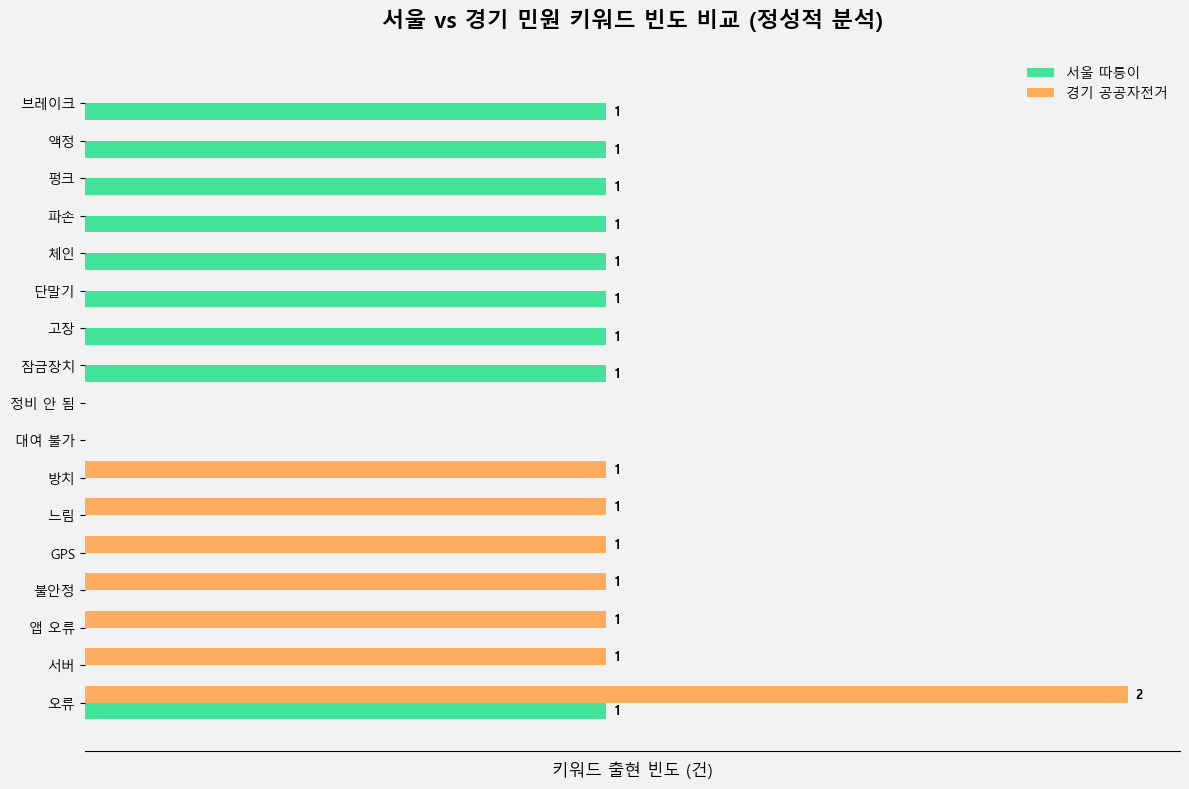

In [187]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

fig, ax = plt.subplots(figsize=(12, 8)) 
fig.set_facecolor('#F2F2F2') 
ax.set_facecolor('#F2F2F2') 

y = np.arange(len(df_compare.index))  
height = 0.45  # 막대 두께
bar_group_offset = 0.3

rects1 = ax.barh(y - height/2, df_compare['서울 따릉이 빈도 (건)'], height, 
                 label='서울 따릉이', color='#30e291', alpha=0.9)
rects2 = ax.barh(y + height/2, df_compare['경기 민원 빈도 (건)'], height, 
                 label='경기 공공자전거', color='#FFA64D', alpha=0.9)

def autolabel_barh(rects):
    for rect in rects:
        width_val = rect.get_width()
        if width_val > 0:
            ax.annotate(f'{width_val:.0f}',
                        xy=(width_val, rect.get_y() + rect.get_height() / 2),
                        xytext=(5, 0),  # 5 points horizontal offset
                        textcoords="offset points",
                        ha='left', va='center', fontsize=9, fontweight='bold')

autolabel_barh(rects1)
autolabel_barh(rects2)

# 축 및 레이블 설정
ax.set_yticks(y)
ax.set_yticklabels(df_compare.index, fontsize=10) # 키워드 이름
ax.set_xlabel('키워드 출현 빈도 (건)', fontsize=12)
ax.set_title('서울 vs 경기 민원 키워드 빈도 비교 (정성적 분석)', fontsize=16, fontweight='bold', pad=20)

ax.legend(loc='upper right', frameon=False) 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False) # Y축 선 제거
ax.spines['bottom'].set_visible(True) # X축 아래 선은 유지
ax.xaxis.set_major_formatter(plt.NullFormatter()) # X축 숫자 제거 (막대 라벨로 대체)
ax.grid(False) 

ax.tick_params(axis='x', length=0) 

plt.tight_layout()
plt.show()

In [153]:
for font in fm.findSystemFonts():
  print(font)

C:\Windows\Fonts\constanz.ttf
C:\Windows\Fonts\SimsunExtG.ttf
C:\Windows\Fonts\Hancom Gothic Bold.ttf
C:\Windows\Fonts\ariblk.ttf
C:\Windows\Fonts\JUMJA.TTF
C:\Windows\Fonts\taileb.ttf
C:\Windows\Fonts\SitkaI.ttc
C:\Windows\Fonts\ariali.ttf
C:\Windows\Fonts\ebrimabd.ttf
C:\Windows\Fonts\Candarai.ttf
C:\Windows\Fonts\ntailu.ttf
C:\Windows\Fonts\arialbi.ttf
C:\Windows\Fonts\YuGothL.ttc
C:\Windows\Fonts\calibriz.ttf
C:\Windows\Fonts\symbol.ttf
C:\Windows\Fonts\LeelUIsl.ttf
C:\Windows\Fonts\HanSantteutDotum-Regular.ttf
C:\Windows\Fonts\HanSantteutDotum-Bold.ttf
C:\Windows\Fonts\webdings.ttf
C:\Windows\Fonts\Sitka.ttc
C:\Windows\Fonts\Candarab.ttf
C:\Windows\Fonts\georgiaz.ttf
C:\Windows\Fonts\verdanaz.ttf
C:\Windows\Fonts\trebucit.ttf
C:\Windows\Fonts\couri.ttf
C:\Windows\Fonts\cambria.ttc
C:\Windows\Fonts\Inkfree.ttf
C:\Windows\Fonts\msyhl.ttc
C:\Windows\Fonts\consolab.ttf
C:\Windows\Fonts\NirmalaS.ttf
C:\Windows\Fonts\HANWing2.ttf
C:\Windows\Fonts\comici.ttf
C:\Windows\Fonts\seguisli.ttf

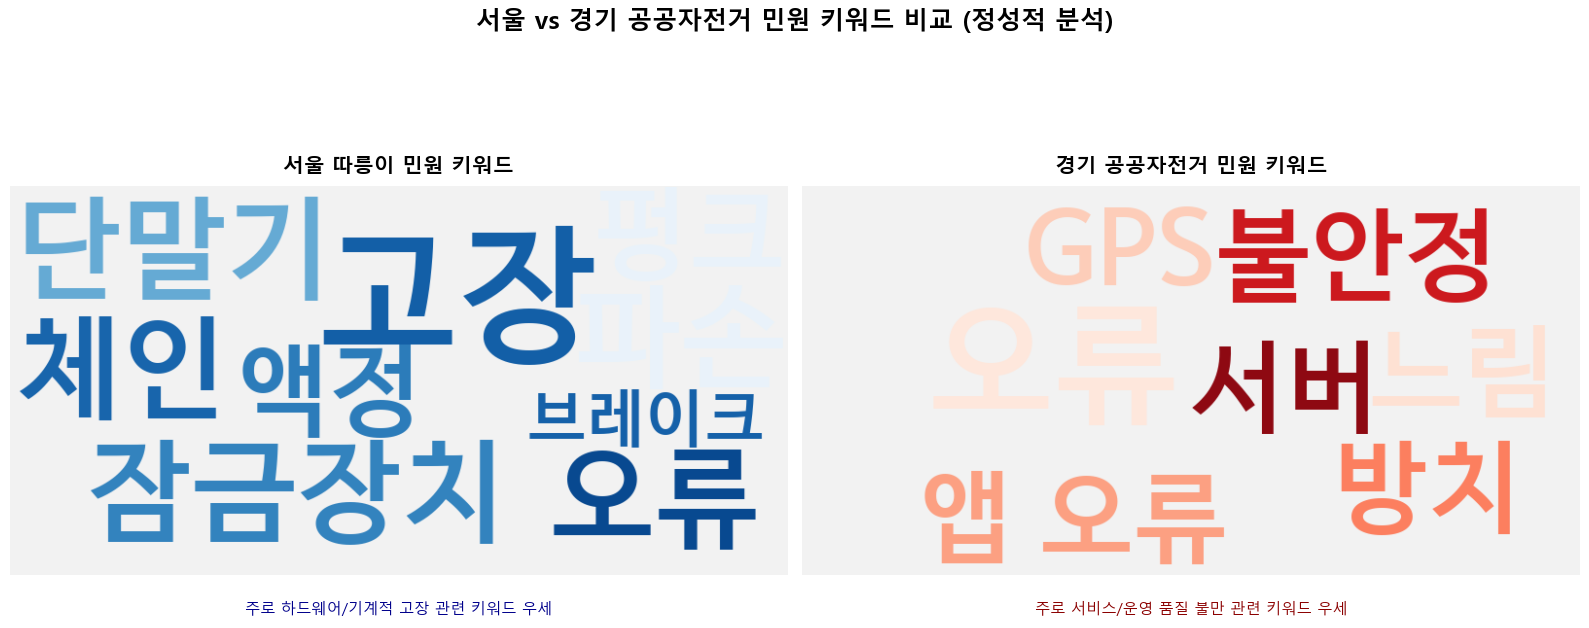

In [168]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

font_path = 'C:\Windows\Fonts\Hancom Gothic Bold.ttf' 

# 워드클라우드 객체 생성 함수
def create_wordcloud(frequency_dict, title, colormap='viridis'):
    wc = WordCloud(
        font_path=font_path,
        background_color="#F2F2F2",
        width=800,
        height=400,
        max_words=20, 
        colormap=colormap
    )
    wordcloud = wc.generate_from_frequencies(frequency_dict)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") # 축 표시 제거
    plt.title(title, fontsize=15, fontweight='bold', pad=10)

# 두 개의 서브플롯으로 워드클라우드 생성
fig, axes = plt.subplots(1, 2, figsize=(16, 7)) 

# 서울 따릉이 워드클라우드
plt.sca(axes[0]) 
seoul_freq_dict = df_compare['서울 따릉이 빈도 (건)'].to_dict()

seoul_freq_dict = {k: v for k, v in seoul_freq_dict.items() if v > 0}
create_wordcloud(seoul_freq_dict, '서울 따릉이 민원 키워드', colormap='Blues')
plt.text(0.5, -0.1, '주로 하드웨어/기계적 고장 관련 키워드 우세', 
         transform=axes[0].transAxes, ha='center', fontsize=11, color='darkblue')

# 경기도 공공자전거 워드클라우드
plt.sca(axes[1]) 
gyeonggi_freq_dict = df_compare['경기 민원 빈도 (건)'].to_dict()
# 빈도 0인 키워드 제거
gyeonggi_freq_dict = {k: v for k, v in gyeonggi_freq_dict.items() if v > 0}
create_wordcloud(gyeonggi_freq_dict, '경기 공공자전거 민원 키워드', colormap='Reds')
plt.text(0.5, -0.1, '주로 서비스/운영 품질 불만 관련 키워드 우세', 
         transform=axes[1].transAxes, ha='center', fontsize=11, color='darkred')


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 전체 제목을 위한 공간 확보
fig.suptitle('서울 vs 경기 공공자전거 민원 키워드 비교 (정성적 분석)', fontsize=18, fontweight='bold', y=1.02)
plt.show()


In [95]:
# 유형별 총합 계산
df_summary = df_compare.groupby('키워드 유형').sum()[['서울 따릉이 빈도 (건)', '경기 민원 빈도 (건)']]
df_summary = df_summary.loc[['하드웨어/기계적 고장', '서비스/운영 품질']] 

# 결과 요약 출력
print("="*50)
print("키워드 유형별 총 빈도 요약")
print("="*50)
df_summary

키워드 유형별 총 빈도 요약


,서울 따릉이 빈도 (건),경기 민원 빈도 (건)
키워드 유형,,
하드웨어/기계적 고장,9,0
서비스/운영 품질,1,8


In [101]:
# 데이터프레임 생성을 위해 변수를 그대로 사용합니다.
data = {
    '지역': ['서울 따릉이', '경기 공공자전거'],
    '대여 건당 유지관리비 (원)': [cost_per_rental_seoul, avg_cost_per_rental]
}
df_cost = pd.DataFrame(data)

# 시각화 설정 (한글 폰트 설정)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

df_cost

,지역,대여 건당 유지관리비 (원)
0,서울 따릉이,808
1,경기 공공자전거,"16,235"


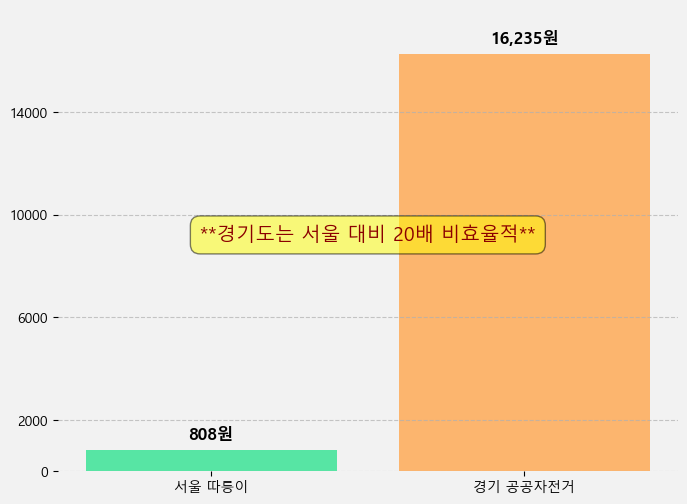

In [128]:
# 배경색 바꾸기
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('#F2F2F2') 
ax.set_facecolor('#F2F2F2')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False) # y축 선 제거
ax.spines['bottom'].set_visible(False) # x축 선 제거

custom_yticks = [0, 2000, 6000, 10000, 14000] 
ax.set_yticks(custom_yticks) 

colors = ['#30e291', '#FFA64D']
bars = ax.bar(df_cost['지역'], df_cost['대여 건당 유지관리비 (원)'], color=colors, alpha=0.8)

# 데이터 라벨 추가
def autolabel_cost(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:,.0f}원',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

autolabel_cost(bars)

# 제목 및 레이블
# ax.set_title('서울 vs 경기: 대여 건당 유지관리비 비교', fontsize=15, fontweight='bold')
# ax.set_ylabel('대여 건당 유지관리비 (원)', fontsize=12)
ax.set_ylim(0, 18000) # 경기도 값보다 약간 높게 설정

# 격차 텍스트 추가
gap_ratio = avg_cost_per_rental / cost_per_rental_seoul
ax.text(0.5, 0.5, f'**경기도는 서울 대비 {gap_ratio:.0f}배 비효율적**', 
        transform=ax.transAxes, ha='center', fontsize=14, color='darkred', 
        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5))


# 그리드 추가
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show();


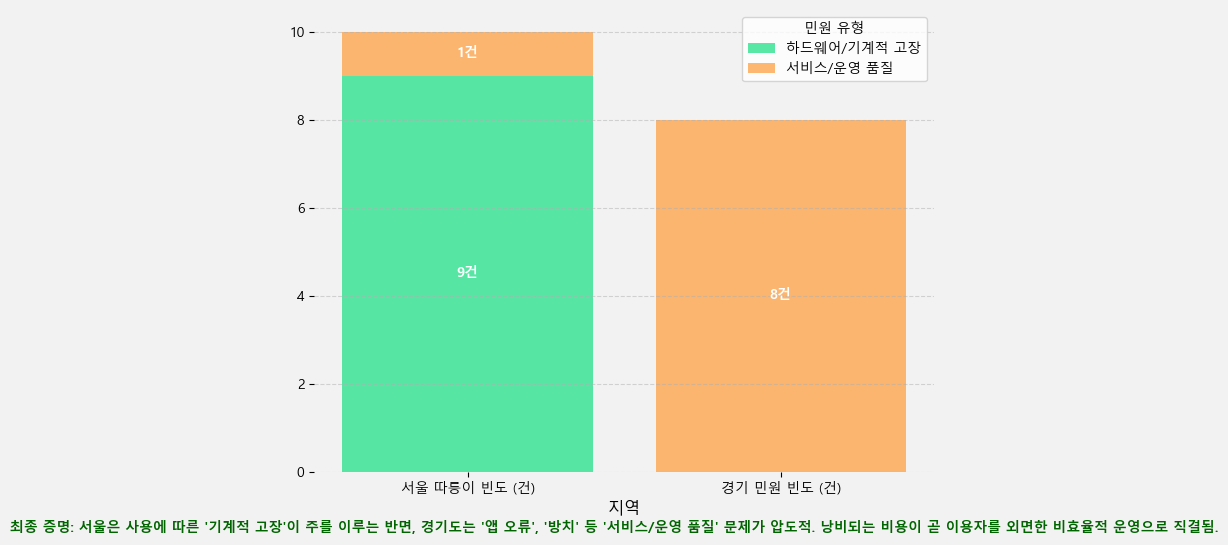

In [127]:
# 누적 막대 그래프를 위한 데이터 변환 
df_plot = df_summary.T
df_plot.index.name = '지역'

# 배경색 바꾸기
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('#F2F2F2') 
ax.set_facecolor('#F2F2F2')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False) # y축 선 제거
ax.spines['bottom'].set_visible(False) # x축 선 제거

# 데이터 플로팅 (누적 막대 그래프)
bottom = np.zeros(len(df_plot))
colors = ['#30e291', '#FFA64D']
labels = ['하드웨어/기계적 고장', '서비스/운영 품질']

for i, col in enumerate(df_plot.columns):
    bars = ax.bar(df_plot.index, df_plot[col], 
                  bottom=bottom, label=labels[i], color=colors[i], alpha=0.8)
    bottom += df_plot[col]
    
    # 데이터 라벨 추가
    for bar in bars:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x()
        y = bar.get_y()
        # 해당 섹션의 빈도만 표시
        if height > 0:
            ax.text(x + width/2, y + height/2, 
                    f'{int(height)}건', 
                    ha='center', va='center', fontsize=10, color='white', fontweight='bold')


# 제목 및 레이블
# ax.set_title('서울 vs. 경기: 민원 유형별 빈도 비교 (서비스 품질 격차 입증)', fontsize=15, fontweight='bold')
# ax.set_ylabel('민원 키워드 총 빈도 (건)', fontsize=12)
ax.set_xlabel('지역', fontsize=12)
ax.legend(title='민원 유형', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 최종 결론 텍스트 추가
plt.figtext(0.5, 0.01, 
            "최종 증명: 서울은 사용에 따른 '기계적 고장'이 주를 이루는 반면, 경기도는 '앱 오류', '방치' 등 '서비스/운영 품질' 문제가 압도적. 낭비되는 비용이 곧 이용자를 외면한 비효율적 운영으로 직결됨.", 
            ha="center", fontsize=10, color="darkgreen", fontweight='bold')

plt.show();